# Goegraphical (Country-Based) Study on COVID-19 Based on JHU CSSE Data

## Objectives:
The aim is to study the offcial reports classified based on contries, dates, and confirmed/recovered/death cases to observe the spreading rate of COVID-19. This objective is achieved by visualisation of data in various forms including but not limiting to "Days after N-th Death" and "Days after N-th Daily New COnfirmed Cases".

## Interoduction:
This notebook provided by ZTSIN analysis the geographical data regarding COVID-19 based on the Johns Hopkins University Center for Systems Science and Engineering (JHU CSSE). This dataset is available: [Github](https://github.com/CSSEGISandData/COVID-19.git) and updates daily. A copy of data has been already uploaded to Kaggle dataset collection.

**Disclaimer: The data is provided by JHU CSSE and the author have no claims or responsibilty regarding the publicly availble data.**

## Results
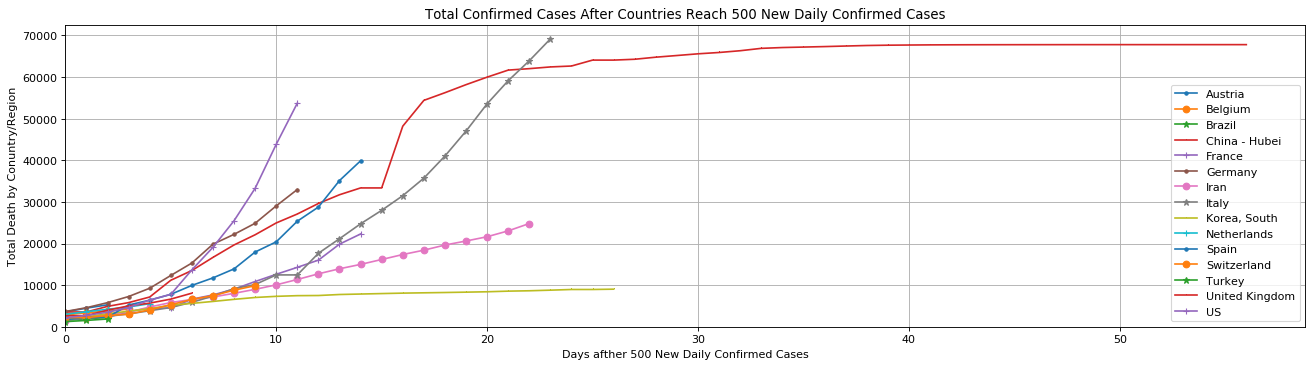

# Notes:
This notebook clone the repository from github to present the latest data. Please make sure the notebook has access to internet using the setting.

# Including Libray
let start with loading the required libraries.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

import csv
import os.path
import datetime
import copy
from datetime import datetime
import matplotlib.pyplot as plt
import copy
import itertools

# Cloning the Git repository
Check if the dataset is available on the dist:
clone if it is not there, update if the clone vesion updated.

In [ ]:
cwd = os.getcwd()

if os.path.isdir('COVID-19'):
  !git -C ./COVID-19 pull
else:
  !git clone https://github.com/CSSEGISandData/COVID-19.git



# Create Output Directory and Refences
* Create a directory to save the new CSV files 
* Create lookup arrays (e.g. filenames)

In [ ]:
if not os.path.isdir('output_files'):
  !mkdir output_files
else:
  print('The output_file is already created.')

db_path = 'COVID-19/csse_covid_19_data/csse_covid_19_time_series'
out_path = 'output_files/'
files =['time_series_covid19_confirmed_global.csv', 'time_series_covid19_deaths_global.csv']
format_str = '%m/%d/%y' # The format

data =[]
data_daily = []
dates = []
locations = []
line_cnt = 0
marker = itertools.cycle((',', '+', '.', 'o', '*')) 

# Reading Files and Merge data
The reported total confirmed, recoverd, and death cases are presented in three seperate files per day. In the following, we are reading these three files and merge data data to a new CSV file called "output.csv". In addition, the daily number of cases (i.e. the new cases in each day, which is the difference of the reported number day to day) is calculated and sved in "output_daily.csv".

In [ ]:
line_cnt = 0
date_cnt = 0
with open(os.path.join(db_path,files[0]),'r') as fi1,\
        open(os.path.join(db_path,files[1]),'r') as fi3, open(os.path.join(out_path,'output.csv'),'w', newline='') as ou,\
                open(os.path.join(out_path,'output_daily.csv'),'w', newline='') as ou1:
  f1 = csv.reader(fi1)
  f3 = csv.reader(fi3)
  writer = csv.writer(ou)
  writer1 = csv.writer(ou1)
  for line in zip(f1,f3):
    line_cnt += 1
    if line_cnt == 1: #header line
      for i in range (len(line[0][4:])):
        dates.append(datetime.strptime(line[0][4+i], format_str))
        date_cnt += 1
      writer.writerow(['Date', 'location', 'Province/State', 'Country', 'Lat', 'Long', 'Total Confirmed', 'Total Death'])
      writer1.writerow(['Date', 'location', 'Province/State', 'Country', 'Lat', 'Long', 'Daily New Confirmed', 'Daily New Death'])
    else:
      loc = '%s - %s' % (line[0][1], line[0][0]) if line[0][0] != '' else line[0][1] 
      locations.append(loc)
      for i in range(date_cnt):
        if line[0][4+i] == '' or line[1][4+i]=='':
          # If the data for a particular location is not available, repeat the last day's data
          data.append([dates[i].strftime("%Y-%m-%d"),loc,line[0][0],line[0][1],line[0][2],line[0][3],line[0][4+i-1],line[1][4+i - 1]])
        else: 
          data.append([dates[i].strftime("%Y-%m-%d"),loc,line[0][0],line[0][1],line[0][2],line[0][3],line[0][4+i],line[1][4+i]])
      
      for i in range(1, date_cnt):
        if not (line[0][4+i] == '' or line[1][4+i]==''):
          data_daily.append([dates[i].strftime("%Y-%m-%d"),loc,line[0][0],line[0][1],line[0][2],line[0][3],int(line[0][4+i]) - int(line[0][3+i]),int(line[1][4+i])-int(line[1][3+i])])


  writer.writerows(data)
  writer1.writerows(data_daily)

In [ ]:
data = pd.read_csv(os.path.join(out_path,'output.csv'))

N_death = 100

date_N_Death = dict()

for loc in locations:
  tmp = data.loc[(data['location'] ==loc) & (data['Total Death'] > N_death)]['Date']
  if len(tmp) != 0:
    date_N_Death.update({loc: min(tmp)})
print('Date countries past %d Deaths'%N_death)
print(date_N_Death)


In [ ]:
data_daily = pd.read_csv(os.path.join(out_path,'output_daily.csv'))
date_N_Confirmed = dict()

N_confirmed = 500

for loc in locations:
  tmp = data_daily.loc[(data_daily['location'] ==loc) & (data_daily['Daily New Confirmed'] > N_confirmed)]['Date']
  if len(tmp) != 0:
    date_N_Confirmed.update({loc: min(tmp)})

print('Date countries past %d Confirmed cases'%N_confirmed)
print(date_N_Confirmed)

In [ ]:
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
tbl_N_death = pd.DataFrame(columns=data.columns)
for loc, date in date_N_Death.items():
  tbl_tmp = copy.deepcopy(data.loc[(data['location'] == loc) & (data['Date']>=date)])
  for index, row in tbl_tmp.iterrows():
  # #   # tbl_tmp.iloc['Date', index] = datetime.strptime(tbl_tmp['Date', index], format_str) - datetime.strptime(date, format_str)
    tbl_tmp.loc[index, 'Date'] = (datetime.strptime(row['Date'], "%Y-%m-%d") - datetime.strptime(date, "%Y-%m-%d")).days
  plt.plot('Date','Total Death',marker=next(marker),data=tbl_tmp,label=loc)
  tbl_N_death = tbl_N_death.append(tbl_tmp)
plt.legend()
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)
plt.grid(True)
plt.title("Total Death after Countries Reach Total %d Death"%N_death)
plt.xlabel("Days afther total %d-Death"%N_death)
plt.ylabel("Total Death by Conuntry/Region")
plt.show()


In [ ]:
day = ['Day%d' % i for i in range(100)]
# day = ['Location'] + day
fig=plt.figure(figsize=(20, 5), dpi= 80, facecolor='w', edgecolor='k')
tbl_N_confirmed = pd.DataFrame(columns=data.columns)
for loc, date in date_N_Confirmed.items():
  tbl_tmp = copy.deepcopy(data.loc[(data['location'] == loc) & (data['Date']>=date)])
  for index, row in tbl_tmp.iterrows():
  # #   # tbl_tmp.iloc['Date', index] = datetime.strptime(tbl_tmp['Date', index], format_str) - datetime.strptime(date, format_str)
    tbl_tmp.loc[index, 'Date'] = (datetime.strptime(row['Date'], "%Y-%m-%d") - datetime.strptime(date, "%Y-%m-%d")).days
  plt.plot('Date','Total Confirmed',marker=next(marker), data=tbl_tmp,label=loc)
  tbl_N_confirmed = tbl_N_confirmed.append(tbl_tmp)
plt.legend()
plt.gca().set_xlim(left=0)
plt.gca().set_ylim(bottom=0)
plt.grid(True)
plt.title("Total Confirmed Cases After Countries Reach %d New Daily Confirmed Cases"%N_confirmed)
plt.xlabel("Days afther %d New Daily Confirmed Cases"%N_confirmed)
plt.ylabel("Total Death by Conuntry/Region")
plt.show()

# Preparing Data to Show on the Map
As the reported cases change drasticly from a country to another one, we are normalising them to a range [0,100] for better visualization on the map.

In [ ]:
data = pd.read_csv(os.path.join(out_path,'output.csv'))
data_lastDay = copy.deepcopy(data[data['Date'] == max(data['Date'])])
max_size = max(data_lastDay['Total Confirmed'])
tmp_size = np.array(data_lastDay['Total Confirmed'])
for i in range(len(tmp_size)):
  val = tmp_size[i]
  size = 200* val/max_size
  size = 10 if size <1 and size > 0 else size
  tmp_size[i] = size
data_lastDay.insert(len(data_lastDay.columns), 'size', tmp_size)

# Visualisaiton on The Map
The following map summerizes the data in a Map. By hovering the mouse over each point, the total number of confimed, recoverd and death cases can be observed.

## Total Confirmed
The size of circle represent the relative number of confimed cases.

In [ ]:
import plotly.express as px

fig = px.scatter_mapbox(data_lastDay, lat="Lat", lon="Long", \
                        size='size', color='Total Confirmed',\
                        hover_name="location", hover_data=["Total Confirmed", "Total Death"],
                        color_discrete_sequence=["fuchsia"], zoom=2, height=600)
fig.update_layout(title='Total Confirmed', mapbox_style="open-street-map",margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

## Total Death
The size of circle represent the relative number of death cases.

In [ ]:
data = pd.read_csv(os.path.join(out_path,'output.csv'))
data_lastDay = copy.deepcopy(data[data['Date'] == max(data['Date'])])
max_size = max(data_lastDay['Total Death'])
tmp_size = np.array(data_lastDay['Total Death'])
for i in range(len(tmp_size)):
  val = tmp_size[i]
  size = 200* val/max_size
  size = 10 if size <1 and size > 0 else size
  tmp_size[i] = size
data_lastDay.insert(len(data_lastDay.columns), 'size', tmp_size)

fig = px.scatter_mapbox(data_lastDay, lat="Lat", lon="Long", \
                        size='size', color='Total Death',\
                        hover_name="location", hover_data=["Total Confirmed", "Total Death"],
                        color_discrete_sequence=["fuchsia"], zoom=2, height=600)
fig.update_layout(title='Total Death', mapbox_style="open-street-map",margin={"r":0,"t":0,"l":0,"b":0})


fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

# Check Our Interactive Analysis
These analysis are done by Power BI.


In [ ]:
%%html
<iframe width="1200" height="600" src="https://app.powerbi.com/view?r=eyJrIjoiNjUyMWI2MTYtZTk4OS00NGJjLTg3MzUtMDdkYTE3NTBlNzY4IiwidCI6IjZlOTM4MWQwLWI3NWQtNDE2Yi05ZjA2LTVhZTRhMDVhNGY2NCIsImMiOjl9" frameborder="0" allowFullScreen="true"></iframe>

In [ ]:
%%html
<iframe width="1200" height="600" src="https://app.powerbi.com/view?r=eyJrIjoiNjQwZWM4MmEtY2QxNi00YTIyLTk5OTItNTUyYzI0YWFjODE5IiwidCI6IjZlOTM4MWQwLWI3NWQtNDE2Yi05ZjA2LTVhZTRhMDVhNGY2NCIsImMiOjl9" frameborder="0" allowFullScreen="true"></iframe>

In [ ]:
%%html
<iframe width="1200" height="600" src="https://app.powerbi.com/view?r=eyJrIjoiNjQwZWM4MmEtY2QxNi00YTIyLTk5OTItNTUyYzI0YWFjODE5IiwidCI6IjZlOTM4MWQwLWI3NWQtNDE2Yi05ZjA2LTVhZTRhMDVhNGY2NCIsImMiOjl9" frameborder="0" allowFullScreen="true"></iframe>